# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [9]:
# Import opencv
import cv2 
# Import uuid
import uuid
# Import Operating System
import os
# Import time
import time

### 1.2 Define Images to Collect

In [3]:
labels = ['awake', 'drowsy']
number_imgs = 20

### 1.3 Setup Folders

In [22]:
IMAGES_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'collectedimages')

In [23]:
if not os.path.exists(IMAGES_PATH):
    if os.name == 'posix':
        !mkdir -p {IMAGES_PATH}
    if os.name == 'nt':
         !mkdir {IMAGES_PATH}
for label in labels:
    path = os.path.join(IMAGES_PATH, label)
    if not os.path.exists(path):
        !mkdir {path}

### 1.4 Capture Images with OpenCV

In [25]:
for label in labels:
    cap = cv2.VideoCapture(1)
    print('Collecting images for {}'.format(label))
    time.sleep(5)
    for imgnum in range(number_imgs):
        print('Collecting image {}'.format(imgnum))
        ret, frame = cap.read()
        imgname = os.path.join(IMAGES_PATH,label,label+'.'+'{}.jpg'.format(str(uuid.uuid1())))
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

### 1.5 Annotate Images with labelImg

In [1]:
!cd Tensorflow/labelImg && python labelImg.py

Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\1.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\1.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\2.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\2.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\3.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\3.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\2.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\2.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\4.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\4.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\5.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\5.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\6.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/label

D:\DrowsinessDetection\Tensorflow\labelImg\labelImg.py:210: DeprecationWarning: an integer is required (got type DockWidgetFeatures).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.dock.setFeatures(self.dock.features() ^ self.dock_features)
External WM_DESTROY received for  QWidgetWindow(0x2075376f1e0, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x207531db820, name="MainWindowClassWindow")


Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\7.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\7.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\9.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\9.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\10.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\10.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\11.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\11.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\12.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\12.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\13.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/data/labels\13.xml
Image:D:\DrowsinessDetection\Tensorflow\workspace\data\images\15.jpg -> Annotation:D:/DrowsinessDetection/Tensorflow/workspace/d

# 2 Review Dataset and Build Image Loading Function

### 2.1 Create TF and Dependencies

In [5]:
import tensorflow as tf
import xml
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [2]:
6000*.9 # 5400 to train

5400.0

In [4]:
6000*.1 # 600 to test

600.0

### 3.2 Move the Matching Labels

In [12]:
for folder in ['train','test']:
    for file in os.listdir(os.path.join('Tensorflow/workspace/data', folder, 'images')):
        
        filename = file.split('.')[0]+'.xml'
        existing_filepath = os.path.join('Tensorflow/workspace/data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('Tensorflow/workspace/data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)    

# Optional: Delete this part

In [32]:
!pip install Augmentor

In [95]:
import Augmentor

In [104]:
p = Augmentor.Pipeline('Tensorflow/workspace/images/data/images')

Initialised with 10 image(s) found.
Output directory set to Tensorflow/workspace/images/data/images\output.

In [101]:
p.rotate90(probability=0.5)
p.flip_left_right(probability=0.8)
p.flip_top_bottom(probability=0.3)
p.resize(probability=1.0, width=120, height=120)

In [ ]:
p.sample(10)

# 4. Setup Paths for Training and Evaluation

### 4.1 Setup

In [3]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

### 4.2 Create Label Map

In [48]:
labels = [{'name':'awake', 'id':1}, {'name':'drowsy', 'id':2}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### 4.3 Create TF records

In [15]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record


In [16]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


### 4.4 Download TF Models Pretrained Models from Tensorflow Model Zoo

In [17]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [6]:
# !pip install wget

In [7]:
# import wget

In [8]:
# wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
# !mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
# !cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

### 4.5 Copy Model Config to Training Folder

In [4]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'

In [5]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

A subdirectory or file Tensorflow\workspace\models\my_ssd_mobnet already exists.


### 4.6 Update Config For Transfer Learning

In [6]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [7]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [8]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [9]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
   

In [10]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [11]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [12]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [13]:
pipeline_config

model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.01
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.997
          scale: true
          epsilon: 0.001
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      arg

# 5. Train the model

In [31]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


# 6. Evaluate the model

In [32]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --checkpoint_dir={}/{}""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet


# 7. Load Train Model From Checkpoint

### 7.1 Import object_detection and deps

In [14]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

### 7.2 Load pipeline config and build a detection model

In [15]:
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

### 7.3 Restore checkpoint

In [16]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()

In [17]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect from An Image

In [18]:
# import dependecies
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [20]:
category_index

{1: {'id': 1, 'name': 'awake'}, 2: {'id': 2, 'name': 'drowsy'}}

In [21]:
IMAGE_PATH = os.path.join(IMAGE_PATH, 'test', '104.jpg')

In [22]:
IMAGE_PATH

'Tensorflow/workspace/images\\test\\104.jpg'

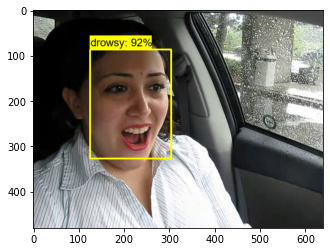

In [23]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 9. Detect in Real-Time

In [24]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [25]:
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break

KeyboardInterrupt: 